In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from collections import defaultdict

In [2]:
# --- Configuration & Styling ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12


In [3]:
FILE_2019 = 'major_cleaned_2019_survey.csv'
FILE_2024 = 'major_cleaned_2024_survey.csv'
FILE_JOBS = 'AGENT_job_analysis_results.csv'


In [4]:
# --- Helper Functions ---

def load_data():
    """Loads all three CSV files."""
    try:
        df_2019 = pd.read_csv(FILE_2019)
        df_2024 = pd.read_csv(FILE_2024)
        df_jobs = pd.read_csv(FILE_JOBS)
        print("All files loaded successfully.")
        return df_2019, df_2024, df_jobs
    except FileNotFoundError as e:
        print(f"Error loading file: {e}")
        print("Please make sure all CSV files are in the same directory as this script.")
        return None, None, None

def get_skill_counts(series, delimiter=';'):
    """
    Splits a series by a delimiter, normalizes, and returns value counts.
    """
    # Drop NaNs and filter out non-string entries just in case
    series = series.dropna().astype(str)
    
    # Split, stack, and strip whitespace
    skills = series.str.split(delimiter).explode().str.strip()
    
    # Normalize common skills
    skill_normalization_map = {
        'bash/shell (all shells)': 'bash/shell',
        'bash/shell/powershell': 'bash/shell',
        'html/css': 'html/css',
        'html 5': 'html/css',
        'c#': 'c#',
        'c++': 'c++',
        'node.js': 'nodejs',
        'react.js': 'react',
        'angular/angular.js': 'angular',
        'ms-sql': 'mssql',
        'microsoft sql server': 'mssql',
        'mysql': 'mysql',
        'postgresql': 'postgresql',
        'postgres': 'postgresql',
        'mongodb': 'mongodb',
        'amazon web services (aws)': 'aws',
        'ms azure': 'azure',
        'microsoft azure': 'azure',
        'google cloud platform': 'gcp',
        'google cloud': 'gcp',
        'ai': 'ai/ml',
        'machine learning': 'ai/ml',
        'deep-learning frameworks': 'ai/ml',
        'tensorflow': 'tensorflow',
        'pytorch': 'pytorch',
        '.net': '.net',
        '.net core': '.net',
        '.net (5+)': '.net'
    }
    
    skills = skills.str.lower().map(lambda x: skill_normalization_map.get(x, x))
    
    # Return as a percentage
    return (skills.value_counts(normalize=True) * 100).rename('Percentage')

def clean_ctc_column(ctc_series):
    """
    Converts 'X.Y LPA' or 'X LPA' string to a numeric value.
    """
    if ctc_series.dtype == 'object':
        # Extract numbers, handling formats like '6.6 LPA' or '10 LPA'
        ctc_numeric = ctc_series.str.extract(r'(\d+\.?\d*)', expand=False).astype(float)
        # Convert LPA (Lakhs Per Annum) to numeric value
        ctc_numeric = ctc_numeric * 100000
        return ctc_numeric
    return pd.to_numeric(ctc_series, errors='coerce')

In [5]:
# --- Question 1: The "Hype" ---
def analyze_hype(df_2019, df_2024):
    """
    Analyzes and plots the change in "desired" languages from 2019 to 2024.
    """
    print("\n--- Analyzing Question 1: Developer 'Hype' (2019 vs 2024) ---")
    
    # Get skill counts for "desire" columns
    hype_2019 = get_skill_counts(df_2019['LanguageDesireNextYear'], delimiter=';')
    hype_2024 = get_skill_counts(df_2024['LanguageWantToWorkWith'], delimiter=';')
    
    # Combine into a single DataFrame
    hype_df = pd.DataFrame({'2019': hype_2019, '2024': hype_2024}).fillna(0)
    
    # Get top 15 based on 2024 hype
    top_hype_2024 = hype_df.nlargest(15, '2024').sort_values('2024', ascending=False)
    
    # Prepare for plotting
    plot_df = top_hype_2024.reset_index().melt(id_vars='index', var_name='Year', value_name='Percentage')
    plot_df.rename(columns={'index': 'Language'}, inplace=True)

    # Plot
    plt.figure(figsize=(15, 8))
    sns.barplot(data=plot_df, x='Language', y='Percentage', hue='Year', palette={'2019': 'lightgray', '2024': 'cornflowerblue'})
    plt.title('Question 1: Developer "Hype" - Top 15 Desired Languages (2019 vs. 2024)', fontsize=16, fontweight='bold')
    plt.ylabel('% of Developers Who Want to Work With It')
    plt.xlabel('Programming Language')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return hype_df

All files loaded successfully.

--- Analyzing Question 1: Developer 'Hype' (2019 vs 2024) ---


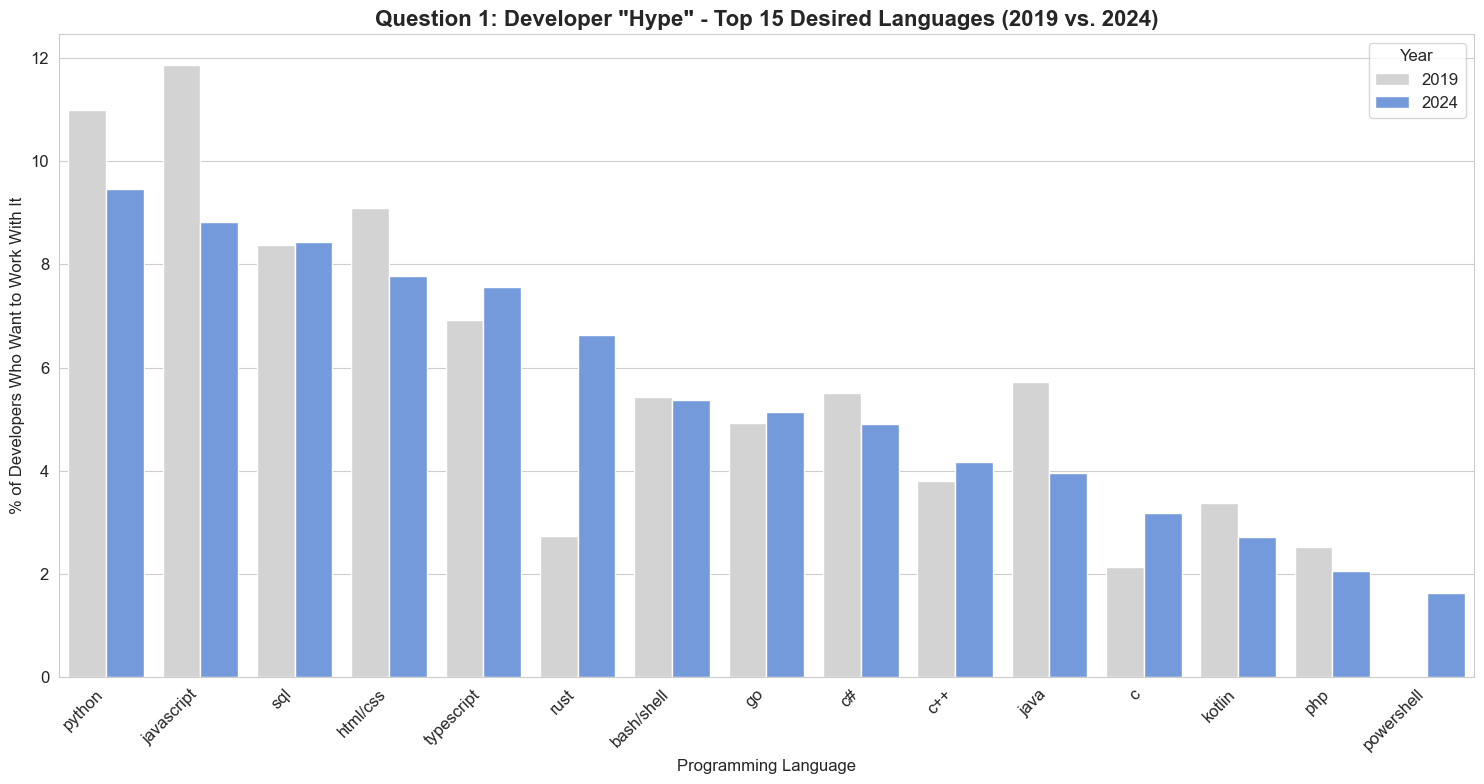


--- Analyzing Question 2: Employer 'Demand' (Job Postings) ---


C:\Users\DELL\AppData\Local\Temp\ipykernel_10720\4205058740.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_demand.values, y=top_demand.index, palette='viridis')


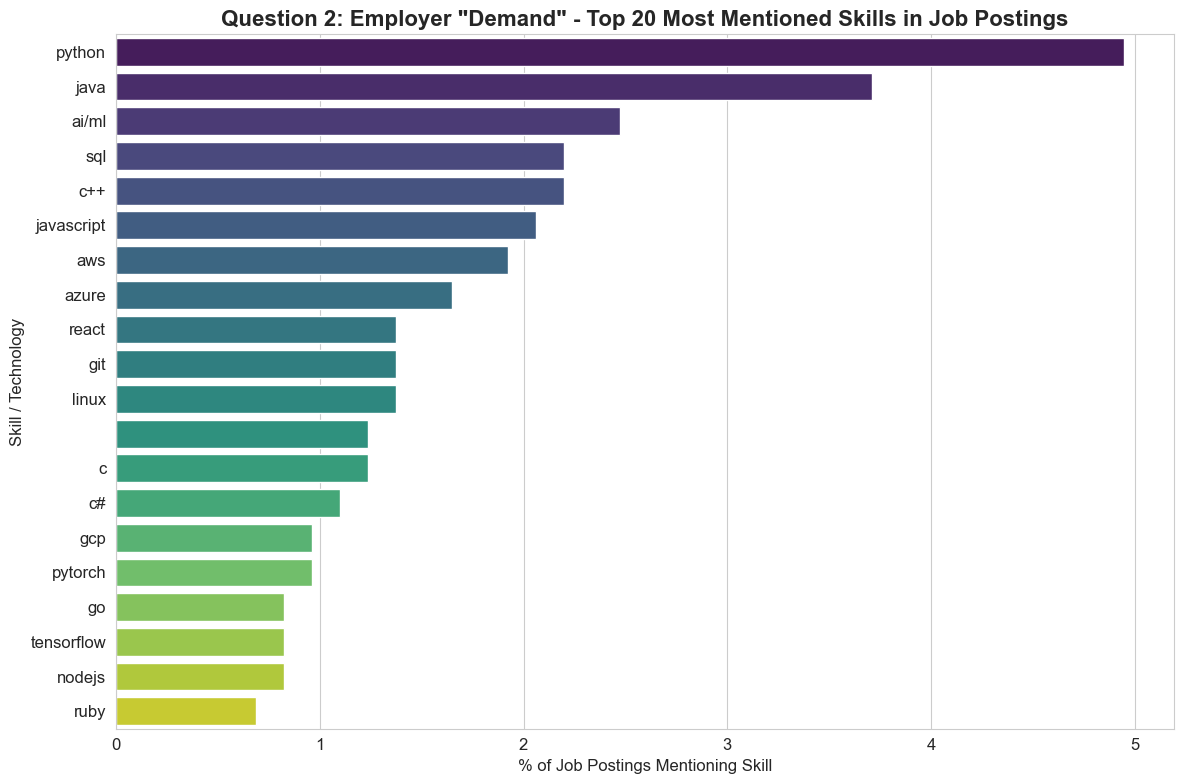


--- Analyzing Question 3: The 'Dollars' (Compensation Analysis) ---


C:\Users\DELL\AppData\Local\Temp\ipykernel_10720\4205058740.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=offered_salary_df.values, y=offered_salary_df.index, palette='plasma')


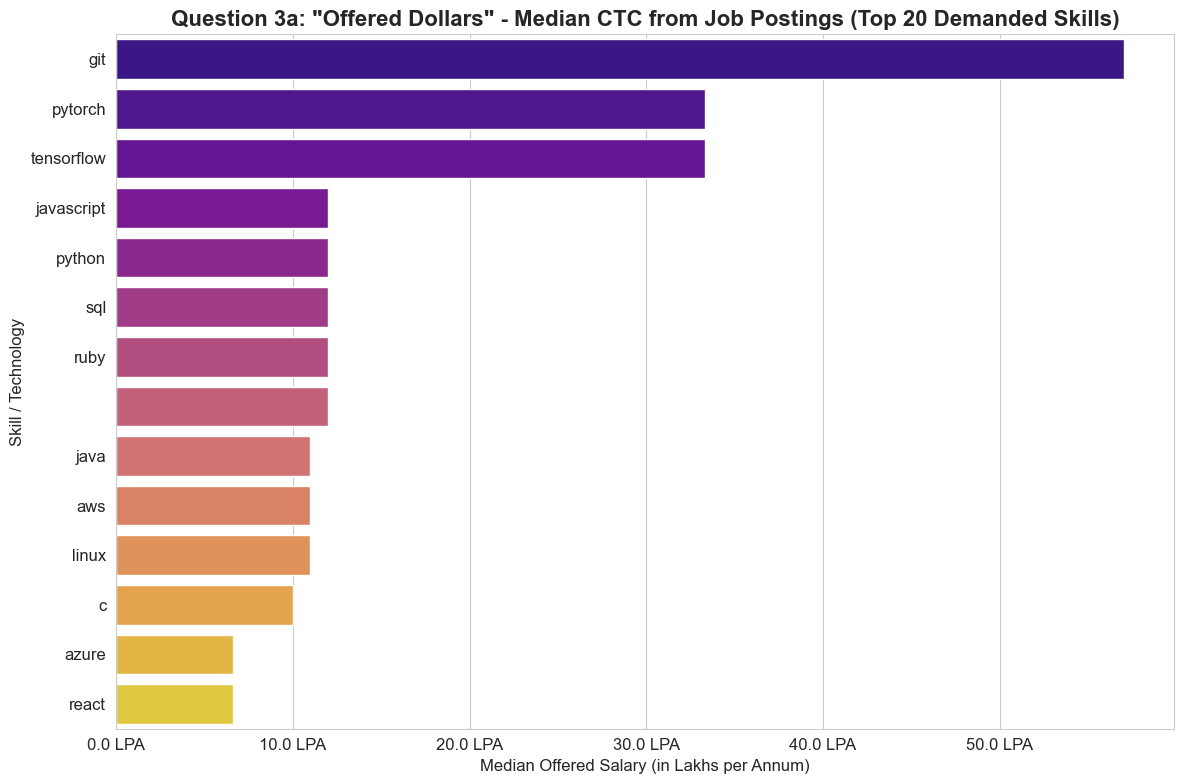

C:\Users\DELL\AppData\Local\Temp\ipykernel_10720\4205058740.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=reported_salary_df.values, y=reported_salary_df.index, palette='cividis')


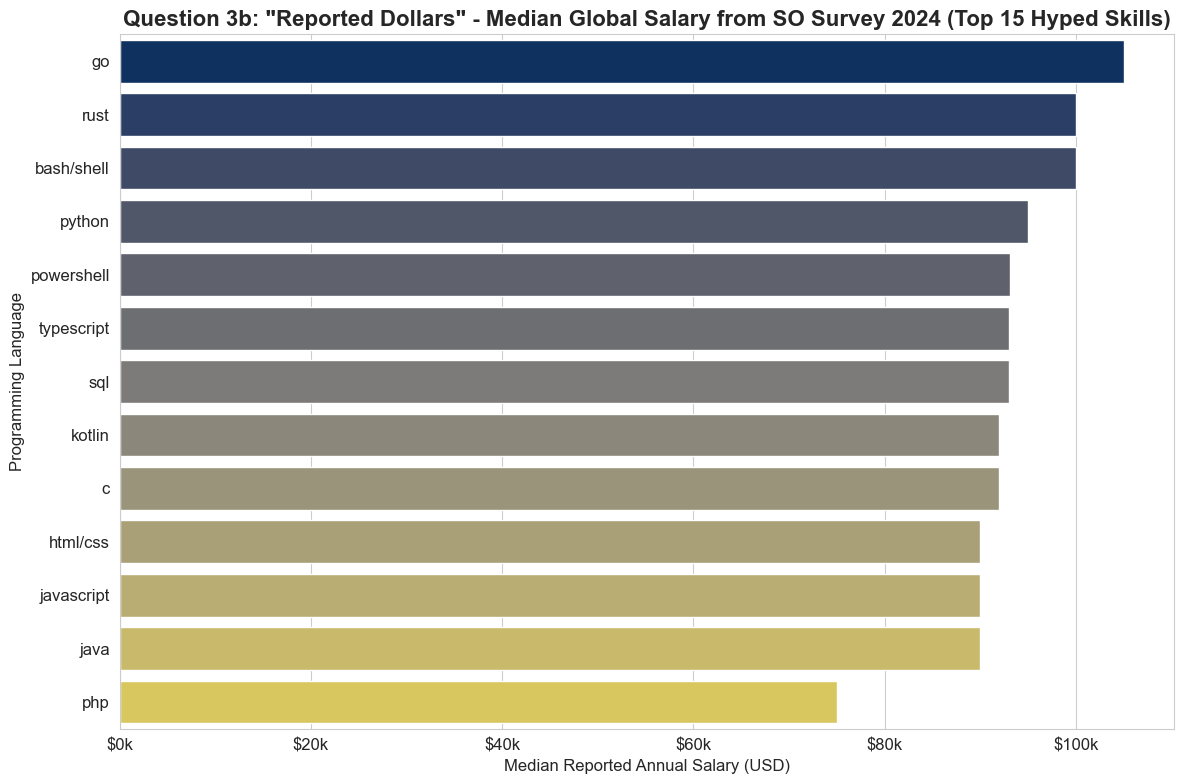


--- Analyzing Question 4: The Synthesis (Hype vs. Demand vs. Dollars) ---


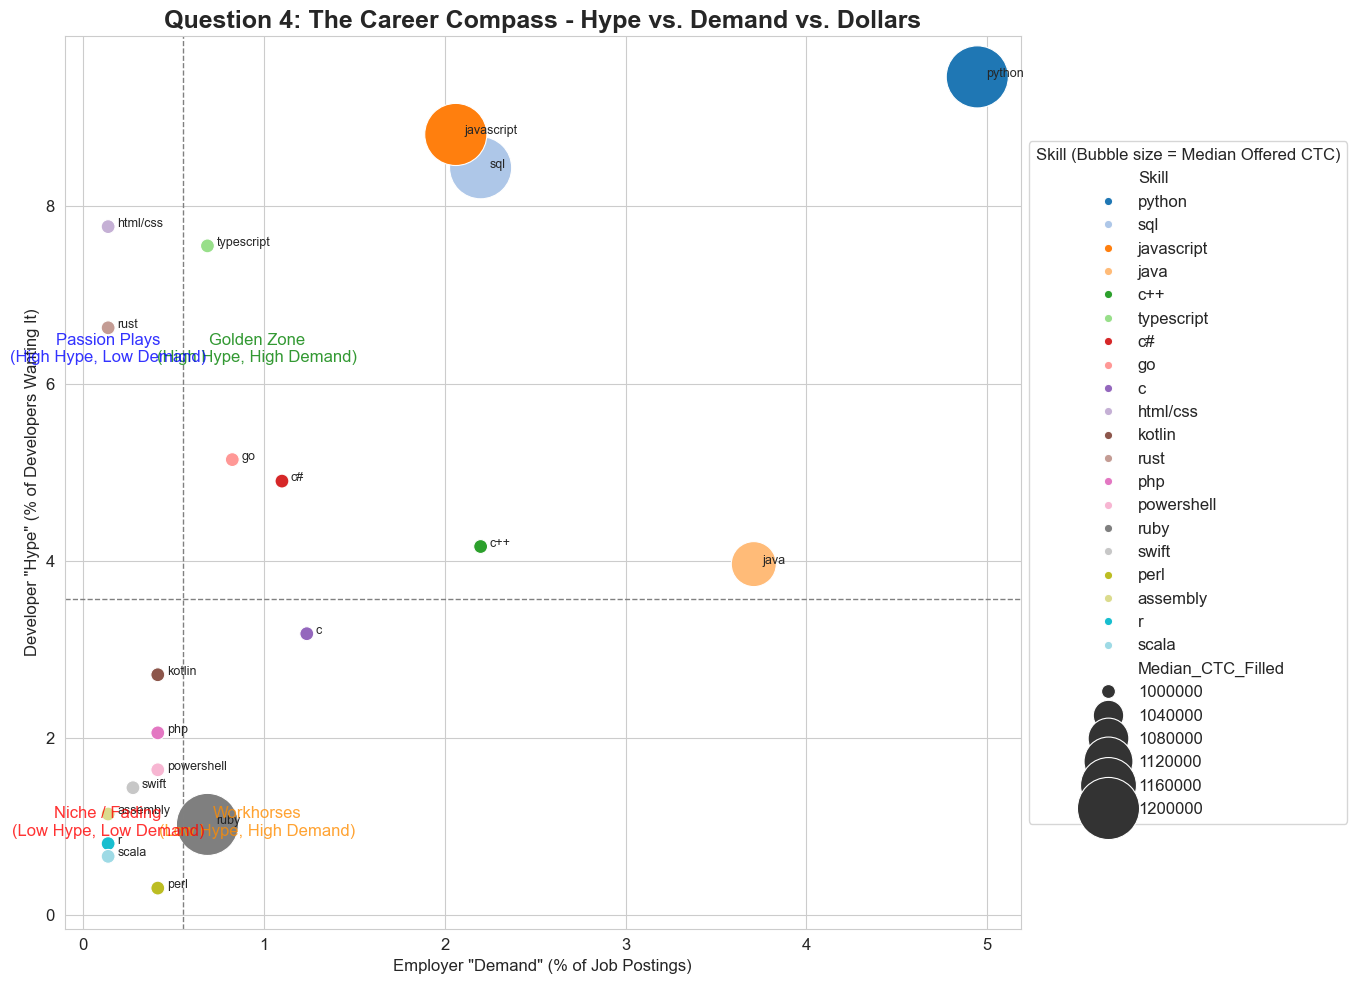


--- Analysis Complete ---
All plots have been generated. Check the popup windows.


In [6]:
# --- Question 2: The "Demand" ---
def analyze_demand(df_jobs):
    """
    Analyzes and plots the most in-demand skills from job postings.
    """
    print("\n--- Analyzing Question 2: Employer 'Demand' (Job Postings) ---")
    
    # Combine all relevant skill columns from the job postings
    skill_cols = ['languages', 'databases', 'platforms', 'web_frameworks', 'aiml', 'tools']
    
    # Create a single "all_skills" series by combining all skill columns
    # We use a comma as the delimiter based on the CSV snippet
    all_skills_series = df_jobs[skill_cols].apply(lambda x: ','.join(x.dropna().astype(str)), axis=1)
    
    # Get normalized counts
    demand_counts = get_skill_counts(all_skills_series, delimiter=',')
    
    # Filter out 'na' which might be a product of joining empty strings
    demand_counts = demand_counts[demand_counts.index != 'na']
    
    # Get top 20
    top_demand = demand_counts.head(20).sort_values(ascending=False)

    # Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x=top_demand.values, y=top_demand.index, palette='viridis')
    plt.title('Question 2: Employer "Demand" - Top 20 Most Mentioned Skills in Job Postings', fontsize=16, fontweight='bold')
    plt.xlabel('% of Job Postings Mentioning Skill')
    plt.ylabel('Skill / Technology')
    plt.tight_layout()
    plt.show()
    
    return demand_counts

# --- Question 3: The "Dollars" ---
def analyze_dollars(df_jobs, df_2024, demand_counts, hype_df):
    """
    Analyzes and plots compensation associated with skills.
    """
    print("\n--- Analyzing Question 3: The 'Dollars' (Compensation Analysis) ---")
    
    # Part 1: Offered Salary (from Job Postings)
    df_jobs['ctc_numeric'] = clean_ctc_column(df_jobs['ctc'])
    df_jobs['all_skills_str'] = df_jobs[['languages', 'databases', 'platforms', 'web_frameworks', 'aiml', 'tools']].apply(
        lambda x: ','.join(x.dropna().astype(str)), axis=1
    ).str.lower()
    
    # Get top 20 demanded skills list
    top_demand_skills = demand_counts.head(20).index
    
    salary_data_offered = {}
    for skill in top_demand_skills:
        # Find jobs that mention this skill
        skill_regex = r'\b' + re.escape(skill) + r'\b' # Use word boundaries
        matching_jobs = df_jobs[df_jobs['all_skills_str'].str.contains(skill_regex, na=False)]
        
        if not matching_jobs.empty and matching_jobs['ctc_numeric'].notna().any():
            # Calculate median salary for these jobs
            median_ctc = matching_jobs['ctc_numeric'].median()
            salary_data_offered[skill] = median_ctc

    offered_salary_df = pd.Series(salary_data_offered).sort_values(ascending=False).rename('Median_Offered_CTC')

    # Plot Offered Salaries
    plt.figure(figsize=(12, 8))
    sns.barplot(x=offered_salary_df.values, y=offered_salary_df.index, palette='plasma')
    plt.title('Question 3a: "Offered Dollars" - Median CTC from Job Postings (Top 20 Demanded Skills)', fontsize=16, fontweight='bold')
    plt.xlabel('Median Offered Salary (in Lakhs per Annum)')
    plt.ylabel('Skill / Technology')
    # Format x-axis to show "LPA"
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/100000:.1f} LPA'))
    plt.tight_layout()
    plt.show()

    # Part 2: Reported Salary (from 2024 Survey)
    # Clean CompTotal
    df_2024['CompTotal'] = pd.to_numeric(df_2024['CompTotal'], errors='coerce')
    # Filter for reasonable salary range (e.g., $10k - $500k) to remove outliers
    df_2024_filtered = df_2024[(df_2024['CompTotal'] > 10000) & (df_2024['CompTotal'] < 500000)]
    
    top_hype_skills = hype_df.nlargest(15, '2024').index

    salary_data_reported = {}
    for skill in top_hype_skills:
        # Find developers who *have worked with* this skill
        skill_regex = r'\b' + re.escape(skill) + r'\b'
        matching_devs = df_2024_filtered[df_2024_filtered['LanguageHaveWorkedWith'].str.contains(skill_regex, na=False, case=False)]
        
        if not matching_devs.empty and matching_devs['CompTotal'].notna().any():
            median_comp = matching_devs['CompTotal'].median()
            salary_data_reported[skill] = median_comp

    reported_salary_df = pd.Series(salary_data_reported).sort_values(ascending=False).rename('Median_Reported_Salary')

    # Plot Reported Salaries
    plt.figure(figsize=(12, 8))
    sns.barplot(x=reported_salary_df.values, y=reported_salary_df.index, palette='cividis')
    plt.title('Question 3b: "Reported Dollars" - Median Global Salary from SO Survey 2024 (Top 15 Hyped Skills)', fontsize=16, fontweight='bold')
    plt.xlabel('Median Reported Annual Salary (USD)')
    plt.ylabel('Programming Language')
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:,.0f}k'))
    plt.tight_layout()
    plt.show()
    
    return offered_salary_df, reported_salary_df

# --- Question 4: The Synthesis ---
def analyze_synthesis(hype_df, demand_counts, offered_salary_df):
    """
    Combines Hype, Demand, and Dollars into a single "Career Compass" plot.
    """
    print("\n--- Analyzing Question 4: The Synthesis (Hype vs. Demand vs. Dollars) ---")
    
    # Combine the data into one master DataFrame
    # Get Hype % for 2024
    synthesis_df = pd.DataFrame({'Hype_Pct': hype_df['2024']})
    
    # Get Demand %
    synthesis_df = synthesis_df.join(demand_counts.rename('Demand_Pct'), how='outer')
    
    # Get Offered Salary
    synthesis_df = synthesis_df.join(offered_salary_df.rename('Median_CTC'), how='outer')
    
    # Clean up: focus on skills where we have at least Hype and Demand data
    synthesis_df = synthesis_df.dropna(subset=['Hype_Pct', 'Demand_Pct'])
    
    # For plotting, fill missing salaries with a small value so they appear small
    synthesis_df['Median_CTC_Filled'] = synthesis_df['Median_CTC'].fillna(synthesis_df['Median_CTC'].min())
    
    # Select top 20 skills based on a combined rank of hype and demand
    synthesis_df['Combined_Rank'] = synthesis_df['Hype_Pct'].rank(ascending=False) + synthesis_df['Demand_Pct'].rank(ascending=False)
    plot_df = synthesis_df.nsmallest(20, 'Combined_Rank').reset_index().rename(columns={'index': 'Skill'})

    # Plot
    plt.figure(figsize=(16, 10))
    s = sns.scatterplot(
        data=plot_df,
        x='Demand_Pct',
        y='Hype_Pct',
        size='Median_CTC_Filled',
        sizes=(100, 2000),
        hue='Skill',
        palette='tab20',
        legend='brief'
    )
    
    # Add labels for each point
    for i in range(plot_df.shape[0]):
        plt.text(
            plot_df['Demand_Pct'][i] + 0.05, 
            plot_df['Hype_Pct'][i], 
            plot_df['Skill'][i], 
            fontdict={'size': 9}
        )
    
    # Add quadrant lines (using median as separator)
    median_demand = plot_df['Demand_Pct'].median()
    median_hype = plot_df['Hype_Pct'].median()
    plt.axvline(median_demand, color='grey', linestyle='--', lw=1)
    plt.axhline(median_hype, color='grey', linestyle='--', lw=1)
    
    # Add quadrant labels
    plt.text(median_demand * 1.75, median_hype * 1.75, 'Golden Zone\n(High Hype, High Demand)', ha='center', fontsize=12, color='green', alpha=0.8)
    plt.text(median_demand * 0.25, median_hype * 1.75, 'Passion Plays\n(High Hype, Low Demand)', ha='center', fontsize=12, color='blue', alpha=0.8)
    plt.text(median_demand * 1.75, median_hype * 0.25, 'Workhorses\n(Low Hype, High Demand)', ha='center', fontsize=12, color='darkorange', alpha=0.8)
    plt.text(median_demand * 0.25, median_hype * 0.25, 'Niche / Fading\n(Low Hype, Low Demand)', ha='center', fontsize=12, color='red', alpha=0.8)
    
    plt.title('Question 4: The Career Compass - Hype vs. Demand vs. Dollars', fontsize=18, fontweight='bold')
    plt.xlabel('Employer "Demand" (% of Job Postings)', fontsize=12)
    plt.ylabel('Developer "Hype" (% of Developers Wanting It)', fontsize=12)
    s.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Skill (Bubble size = Median Offered CTC)')
    
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Make room for legend
    plt.show()


# --- Main Execution ---
def main():
    df_2019, df_2024, df_jobs = load_data()
    
    if df_2019 is not None:
        # Question 1: What's the "Hype"?
        hype_df = analyze_hype(df_2019, df_2024)
        
        # Question 2: What's the "Demand"?
        demand_counts = analyze_demand(df_jobs)
        
        # Question 3: What are the "Dollars"?
        offered_salary_df, reported_salary_df = analyze_dollars(df_jobs, df_2024, demand_counts, hype_df)
        
        # Question 4: The Synthesis
        analyze_synthesis(hype_df, demand_counts, offered_salary_df)
        
        print("\n--- Analysis Complete ---")
        print("All plots have been generated. Check the popup windows.")

if __name__ == "__main__":
    main()